# Ordinary Least Squares on magnet challenge dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapezoid

# Read Dataset

In [2]:
filepath = '/home/nikolasf/Dokumente/01_git/30_Python/MC_UPB/data/input/processed'
material_name = 'ten_materials'
ds = pd.read_pickle(f'{filepath}/{material_name}.pkl.gz')

# Initial edit dataset

In [3]:

ds = ds.drop(columns=[c for c in ds if c.startswith("H_t")])
#ds = ds.query('temp == 25')

# add the saturation flux density. Data from datasheets.
ds.loc[ds['material'] == '3C90', 'b_sat_25'] = 0.47
ds.loc[ds['material'] == '3C94', 'b_sat_25'] = 0.47
ds.loc[ds['material'] == '3E6', 'b_sat_25'] = 0.46
ds.loc[ds['material'] == '3F4', 'b_sat_25'] = 0.41
ds.loc[ds['material'] == '77', 'b_sat_25'] = 0.51
ds.loc[ds['material'] == '78', 'b_sat_25'] = 0.48
ds.loc[ds['material'] == 'N27', 'b_sat_25'] = 0.50
ds.loc[ds['material'] == 'N30', 'b_sat_25'] = 0.38
ds.loc[ds['material'] == 'N49', 'b_sat_25'] = 0.49
ds.loc[ds['material'] == 'N87', 'b_sat_25'] = 0.49


print(ds['ploss'])
ds['ploss'] = np.log(ds['ploss'])
ds['freq'] = np.log(ds['freq'])

print(ds['ploss'])

# print(ds)

0           2319.444340
1           3191.235893
2           4341.086142
3           5795.359190
4           7813.691725
              ...      
186742     68121.464932
186743     85924.743654
186744    108411.839417
186745    135853.384296
186746    171849.522231
Name: ploss, Length: 186747, dtype: float64
0          7.749083
1          8.068164
2          8.375880
3          8.664813
4          8.963633
            ...    
186742    11.129048
186743    11.361227
186744    11.593693
186745    11.819332
186746    12.054375
Name: ploss, Length: 186747, dtype: float64


### Adapted Wilhelm example

In [4]:
"""Run linear regression with regularization training"""
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor
from tqdm import tqdm
from pprint import pprint
from utils.experiments import get_stratified_fold_indices, PROC_SOURCE
from utils.metrics import calculate_metrics

pd.set_option("display.max_columns", None)


def objective(trial):

    n_estimators = 429 # trial.suggest_int('n_estimators', 10, 500)
    print(f'{n_estimators = }')
    criterion = trial.suggest_categorical('criterion', ['squared_error'])
    print(f"{criterion = }")
    learning_rate = 0.12 # trial.suggest_float('learning_rate', 0.01, 1)
    print(f"{learning_rate = }")
    
    exp_log = {}
    for material_lbl, mat_df in tqdm(ds.groupby("material"), desc="Train across materials"):
        full_b = mat_df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy()
        dbdt = full_b[:, 1:] - full_b[:, :-1]
        mat_df = mat_df.reset_index(drop=True)

        x_vec = np.linspace(0, 1023, 1024)
        b_vec = []
        for value in x_vec:
            b_vec.append(f'B_t_{int(value)}')
        mat_df["b"] = mat_df[b_vec].values.tolist()
        x_vec = None
        b_vec = None
        mat_df['delta_b'] = mat_df['b'].map(lambda x: np.max(x) - np.min(x))

        # figure out integral_part 
        mat_df["time_s"] = mat_df["freq"].map(lambda x: np.linspace(0, 1/x, 1024))

        # derivation
        # according to https://im-coder.com/zweite-ableitung-in-python-scipy-numpy-pandas.html
        mat_df["fitted_function"] = mat_df.apply(lambda x: UnivariateSpline(x["time_s"], x["b"], s=0, k=4), axis=1)
        mat_df["amplitude_2nd_derivation"] = mat_df["fitted_function"].apply(lambda x: x.derivative(n=2))
        mat_df["integrated_function"] = mat_df.apply(lambda x: trapezoid(np.abs(x["amplitude_2nd_derivation"](x["time_s"])), x["time_s"]), axis=1)     

        mat_df["integral_part"] = mat_df["integrated_function"] / mat_df["delta_b"]

        # cross validation 'kfold'
        kfold_lbls = get_stratified_fold_indices(mat_df, 4)
        mat_df_proc = mat_df.assign(
            kfold=kfold_lbls,
            # integral_part=mat_df['integral_part'],
            #delta_b=mat_df['delta_b'],
            #b_sat=mat_df['b_sat_25'],
            db_bsat_1 = mat_df['delta_b'] / mat_df['b_sat_25'],
            db_bsat_2 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 2,
            db_bsat_3 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 3,
            db_bsat_4 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 4,
            db_bsat_5 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 5,
            db_bsat_6 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 6,
            temp_square = mat_df['temp'] ** 2,
            t2 = (mat_df['integral_part'] ** (-1)) / 2,
            t3 = -(mat_df['integral_part'] ** (-2)) / 6,
            t4 = ( 3 * mat_df['integral_part'] ** (-2) + 2 * mat_df['integral_part'] ** (-3)) / 24
            # more features imaginable (count of spikes e.g.)
        ).drop(
            columns=[c for c in mat_df if c.startswith("B_t_")] + ["material"] + ['b'] + ['time_s'] + ['fitted_function'] +['amplitude_2nd_derivation'] + ['integrated_function'] + ['b_sat_25']
        )  # drop B curve

        # training result container
        results_df = mat_df_proc.loc[:, ["ploss", "kfold"]].assign(pred=0)
        x_cols = [c for c in mat_df_proc if c not in ["ploss", "kfold"]]
        print(x_cols)
        for kfold_lbl, test_fold_df in mat_df_proc.groupby("kfold"):
            train_fold_df = (
                mat_df_proc.query("kfold != @kfold_lbl")
                .reset_index(drop=True)
                .drop(columns="kfold")
            )
            assert len(train_fold_df) > 0, "empty dataframe error"
            y = train_fold_df.pop("ploss")
            X = train_fold_df.loc[:, x_cols]

            mdl = GradientBoostingRegressor(n_estimators=n_estimators, criterion=criterion, learning_rate=learning_rate) # GradientBoostingRegressor() # HistGradientBoostingRegressor() # RandomForestRegressor(n_estimators = 100) #LinearRegression() # Ridge()  # 
            mdl.fit(X.to_numpy(), y.to_numpy())
            pred = mdl.predict(test_fold_df.loc[:, x_cols].to_numpy())
            results_df.loc[results_df.kfold == kfold_lbl, "pred"] = pred

        # book keeping
        exp_log[material_lbl] = calculate_metrics(
            np.exp(results_df.loc[:, "pred"]), np.exp(results_df.loc[:, "ploss"])
        )
    print(mdl.__class__.__name__)
    print(f"{n_estimators = }")
    print(f"{learning_rate = }")
    print(mdl.feature_importances_)
    
    print("Overall Score")
    score = pd.DataFrame(exp_log).T
    print(score)

    added_avg_abs_rel_err = score['avg-abs-rel-err'].sum()
    print('sum error')
    print(added_avg_abs_rel_err)
    
    # feature importances
    feat_importances = pd.Series(mdl.feature_importances_, index=x_cols)
    feat_importances.nlargest(20).plot(kind='barh')
    
    return added_avg_abs_rel_err

In [5]:
# print(mdl.features_importances_)


### Run objective function single

In [6]:
# objective()

### Run objective function in a hyperparameter optimization loop

[I 2023-09-01 18:18:23,138] A new study created in memory with name: no-name-f2a829fb-8b0a-4504-af84-88f86dd67804


n_estimators = 429
criterion = 'squared_error'
learning_rate = 0.12


Train across materials:   0%|          | 0/10 [00:00<?, ?it/s]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  10%|█         | 1/10 [06:26<58:01, 386.79s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  20%|██        | 2/10 [12:21<49:01, 367.74s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  30%|███       | 3/10 [13:18<26:22, 226.07s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  40%|████      | 4/10 [14:10<15:44, 157.34s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  50%|█████     | 5/10 [15:40<11:05, 133.04s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  60%|██████    | 6/10 [17:13<07:57, 119.29s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  70%|███████   | 7/10 [18:47<05:32, 110.99s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  80%|████████  | 8/10 [19:59<03:17, 98.57s/it] 

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials:  90%|█████████ | 9/10 [21:01<01:27, 87.11s/it]

['freq', 'temp', 'delta_b', 'integral_part', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 'db_bsat_4', 'db_bsat_5', 'db_bsat_6', 'temp_square', 't2', 't3', 't4']


Train across materials: 100%|██████████| 10/10 [26:29<00:00, 158.94s/it]


GradientBoostingRegressor
n_estimators = 429
learning_rate = 0.12
[2.06418021e-01 8.06226728e-03 1.32467169e-01 1.05803948e-02
 2.06481805e-01 1.98597091e-01 1.36151741e-02 9.97181335e-02
 8.57668036e-02 2.73301285e-02 5.89927184e-03 5.05062462e-03
 8.22588970e-06 4.88881709e-06]
Overall Score
               mse           mae  avg-abs-rel-err  percentile_5_rel_err  \
3C90  5.747352e+08  10906.286784         0.101975              0.006364   
3C94  1.355407e+09  16328.585135         0.094143              0.006140   
3E6   3.341944e+09  29803.678360         0.059587              0.003773   
3F4   2.670437e+08   7190.316896         0.051791              0.003463   
77    1.338008e+09  17121.430638         0.091679              0.006102   
78    8.752974e+08  13631.926519         0.089513              0.006059   
N27   1.314649e+09  16455.097260         0.073434              0.005112   
N30   5.491791e+09  30373.516341         0.063542              0.004187   
N49   3.436818e+09  27572.7742

[I 2023-09-01 18:44:53,511] Trial 0 finished with value: 0.7884109379081039 and parameters: {'criterion': 'squared_error'}. Best is trial 0 with value: 0.7884109379081039.


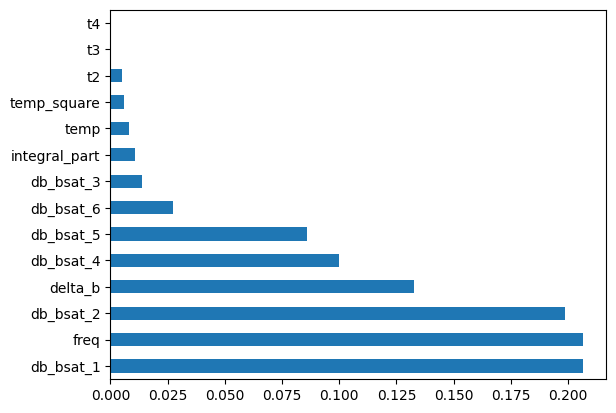

In [7]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1, n_jobs=2)
#print(study.best_trial)